In [1]:
# Importer les bibliothèques

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import glob
import imageio
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Préparer le jeu de données 

In [4]:
from PIL import Image
from sklearn.model_selection import train_test_split

# Charger les images originales
data_directory = "C:/Users/Utilisateur/Documents/Python/python_Ynnov/Minst/mes_images"
image_files = os.listdir(data_directory)
images = []
labels = [0,1,2,3,4,5]

for filename in image_files:
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join(data_directory, filename)).convert('L')  # Convertir en niveaux de gris
        images.append(img)

# Redimensionner les images et créer le jeu d'entraînement 
X_train = []
y_train = []


while len(X_train) < 60000:
    for i, img in enumerate(images):
        resized_img = img.resize((28, 28), Image.LANCZOS)  # Redimensionner l'image
        X_train.append(np.array(resized_img))  # Convertir en tableau numpy
        y_train.append(labels[i])

# Convertir en tableaux numpy et ajouter une dimension au tenseur train_images
X_train = np.array(X_train)
train_labels = np.array(y_train)

train_images = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normaliser les images dans les valeurs [-1, 1]

# Afficher les dimensions des ensembles de données
print("Dimensions des ensembles d'entraînement, de validation et de test :")
print("Entraînement :", train_images.shape, train_labels.shape)

Dimensions des ensembles d'entraînement, de validation et de test :
Entraînement : (60000, 28, 28, 1) (60000,)


In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# Regrouper et mélanger les données
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
# Architecture du GAN - le générateur

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [9]:
# Utiliser le générateur (pas encore formé) pour générer une image

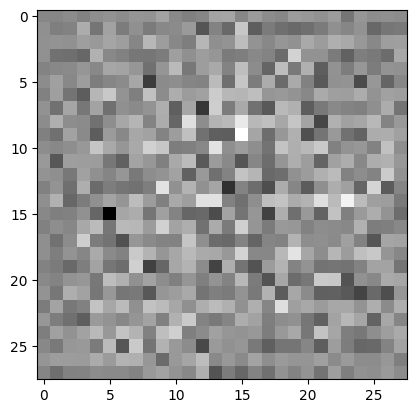

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
# Architecture du GAN - le discriminateur

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [13]:
# Utiliser le discriminateur (pas encore formé) pour évaluer une image
    # Si le score est < 0, c'est que l'image est jugée comme factice

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00179505]], shape=(1, 1), dtype=float32)


In [15]:
# Définir les fonctions de perte et les optimiseurs pour les deux modèles 

In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# Discriminateur :
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
# Générateur :
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
# Enregistrer des points de contrôle 

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
# Définir la boucle d'entraînement

In [23]:
EPOCHS = 24
noise_dim = 100
num_examples_to_generate = 12
BATCH_SIZE = 256

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 12 epochs
    if (epoch + 1) % 12 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [26]:
# Générer et enregistrer des images

In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [28]:
# Entraîner le modèle

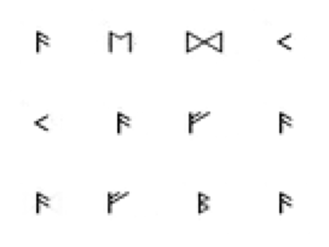

In [29]:
train(train_dataset, EPOCHS)

In [30]:
# Restaurer le dernier point de contrôle

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

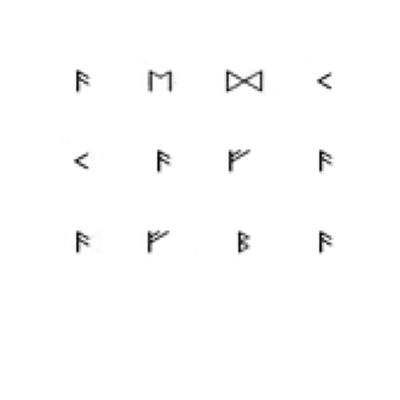

In [32]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [33]:
# Utilisez imageio pour créer un gif animé à partir des images enregistrées lors de la formation

In [2]:
import tensorflow_docs.vis.embed as embed
import imageio.v2 as imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)

NameError: name 'glob' is not defined